In [19]:
import pandas as pd
import json
from config import *
from ppp_prediction.utils import load_data
from ppp_prediction.model import fit_best_model
import pickle


import matplotlib.pyplot as plt
import seaborn as sns
from ppp_prediction.plot.utils import save_fig

params = {
    "axes.labelsize": 14,  # fontsize for x and y labels (was 10)
    "font.size": 8,  # was 10
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "text.usetex": False,
    "figure.figsize": [5, 5],
    "font.family": "Calibri",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 2,
    # set title fontsize
    "axes.titlesize": 15,
    "axes.titleweight": "bold",
    "figure.titlesize": 15,
    # label
    "axes.labelweight": "bold",
}

plt.rcParams.update(params)

%config InlineBackend.figure_format = "svg"
%config InlineBackend.print_figure_kwargs = {"dpi" : 300}



In [20]:
diseaserawDir = dataDir / "label"



def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [21]:
# Prot_train = load_data(dataDir / "imputeData" / "Prot_train.feather")
# held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
# held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")
# print(RF_train.info())

# RF_train = load_data(dataDir / "imputeData" / "RF_train.feather")
NMR_train = load_data(dataDir / "imputeData" / "NMR_train.feather")
held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")
print(NMR_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232103 entries, 0 to 232102
Columns: 170 entries, eid to Valine
dtypes: float64(169), object(1)
memory usage: 301.0+ MB
None


In [22]:



def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [23]:
drop_dict = {
    "T2D": ["Glucose", "glucose", "glycated_haemoglobin_hba1c"],
    "Stroke": None,
    "Heart_Failure": None,
    "Coronary_Artery_Disease": None,
    "Chronic_kidney_disease": ["Creatinine", "creatinine"],
    "Atrial_fibrillation_or_flutter": None,
    "PAD": None,
    "Hypertension": None,
    "Venous_Thromboembolism": None,
    "CMD": ["Creatinine", "creatinine", "Glucose", "glucose"],
}


def drop_value_from_list(l, v=None):
    if v is None:
        return l
    if len(v) == 0:
        return l
    will_drop = []
    will_keep = []
    for i in l:
        if i in v:
            will_drop.append(i)
        else:
            will_keep.append(i)
    print(f"will drop {will_drop}")
    return will_keep
    # will_drop.extend(drop_dict[i])

In [24]:
list(diseaserawDir.glob("*"))

[PosixPath('V4/data/label/Coronary_Artery_Disease.feather'),
 PosixPath('V4/data/label/Heart_Failure.feather'),
 PosixPath('V4/data/label/Hypertension.feather'),
 PosixPath('V4/data/label/Stroke.feather'),
 PosixPath('V4/data/label/Atrial_fibrillation_or_flutter.feather'),
 PosixPath('V4/data/label/Chronic_kidney_disease.feather'),
 PosixPath('V4/data/label/PAD.feather'),
 PosixPath('V4/data/label/Venous_Thromboembolism.feather'),
 PosixPath('V4/data/label/T2D.feather')]

In [25]:
from ppp_prediction.model_v2.models import (
    fit_best_model_v2,
    fit_ensemble_model_simple_v2,
    fit_lightgbm,
    fit_xgboost,
)

In [26]:
modelSaveDir = outputDir / "0x-tabpfn-NMR"

In [27]:

import numpy as np 
def get_sig_vars(tgt_dir = "V2/output/02-risk-model/02-Result/", tgt_name="NMR", suffix = "glmnet/bootstrap/bootstrap_coef_df.csv", topk=50):
    tgt_dir = Path(tgt_dir)
    all_disease = list(tgt_dir.glob("*"))

    res_dict = {}
    for disease in all_disease:
        disease_name = disease.name
        tgt_coef_file = tgt_dir / disease_name / tgt_name/ suffix
        if tgt_coef_file.exists():
            coef_df = pd.read_csv(tgt_coef_file)
            coef_df.set_index(coef_df.columns[0], inplace=True)
            coef_df = np.abs(coef_df.mean(axis=1)).sort_values(ascending=False)
            coef_df = coef_df[coef_df > 0].head(topk).index.tolist()

            res_dict[disease_name] = coef_df
    return res_dict
            
            
            
            
        
    
    

In [35]:
from collections import defaultdict
from ppp_prediction.cox import run_cox

# from ppp_prediction.model import run_glmnet
E = "incident"
T = "survTime"
disease_dict = defaultdict(dict)
combination_dict = get_sig_vars()

for disease_dir in diseaserawDir.glob("*"):
    disease_name = disease_dir.stem


    disease_df = load_data(disease_dir)

    disease_train = disease_df.merge(NMR_train, on="eid", how="inner")
    disease_data_held_out_train = disease_df.merge(
        held_out_train, on="eid", how="inner"
    )
    disease_data_held_out_test = disease_df.merge(held_out_test, on="eid", how="inner")

    disease_modelSaveDir = modelSaveDir / disease_name
    disease_modelSaveDir.mkdir(parents=True, exist_ok=True)
    if (disease_modelSaveDir / "~metrics.csv").exists():
        print(f"{disease_name} already exists")
        
        # c_disease_dict = pickle.load(
        #     open(disease_modelSaveDir / "disease_dict.pkl", "rb")
        # )
    else:
        final_need_cols = ["eid", "incident", "survTime", "date"]
        c_model_dict = {}

        # for name, combination in clinical_risk_dict.items():
        # name = "PANEL"
        # combination = clinical_risk_dict[name]
        combination = list(NMR_train.columns)[1:]
        

        # split data 

        # 1) full data ; 2) random sample data 
        n_case_train = int(disease_train["incident"].sum())
    
        disease_train = disease_train.dropna(subset=["incident", *combination])
        disease_train_case = disease_train.query("incident == 1").sample(n=10 if n_case_train > 5000 else n_case_train)
        # disease_train_control = disease_train.query("incident == 0").sample(n=5000 if n_case_train > 5000 else n_case_train)
        disease_train_control = disease_train.query("incident == 0").sample(n=10)


        # # train model 
        # # metrics_res = [] 
        # score_name_list = ["lasso_full", "xgboost_full"]
        # # basic_cols = ["eid", E, T, "incident", "survTime", "date"]
        
        # disease_data_held_out_train = disease_data_held_out_train.dropna(
        #     subset=["incident", *combination]
        # )
        # X_held_out_train = disease_data_held_out_train[combination]
        # y_held_out_train = disease_data_held_out_train["incident"]

        # disease_data_held_out_test = disease_data_held_out_test.dropna(
        #     subset=["incident", *combination]
        # )
        # X_held_out_test = disease_data_held_out_test[combination]
        # y_held_out_test = disease_data_held_out_test["incident"]
         


        # # Test model 1) full lasso xgboost 2) sampled and features from 5, 10, 20, 50, 100, 200 of lasso, AutoTabPFN, xgboost

        # # 1) Lasso full  
        # lasso_full_savedir = disease_modelSaveDir / "lasso_full.pkl"
        # if lasso_full_savedir.exists():
        #     lasso_full = pickle.load(open(lasso_full_savedir, "rb"))
        #     print(f"{disease_name} lasso_full loaded")
 
        # else: 
        #     (lasso_full, *_) = fit_best_model(
        #         train_df=disease_train,
        #         test_df=disease_data_held_out_test,
        #         X_var=combination,
        #         y_var="incident",
        #         method_list="Lasso",
        #         cv=3,
        #         engine="cuml",
        #     )
                
        #     pickle.dump(
        #         lasso_full, open(lasso_full_savedir, "wb")
        #     )
        
        # disease_data_held_out_test["lasso_full"] = get_predict_v2_from_df(
        #     lasso_full, disease_data_held_out_test, combination
        # )

        # del lasso_full

        # # xgboost full 
        # xgboot_full_savedir = disease_modelSaveDir / "xgboost_full.pkl"
        # if (disease_modelSaveDir / "xgboost_full.pkl").exists():
        #     print(f"{disease_name} xgboost_full loaded")
        #     xgboost_full_tuned = pickle.load(open(xgboot_full_savedir, "rb"))
        # else:
            
        #     xgboost_full_tuned, *_ = fit_xgboost(
        #         train = disease_train,
        #         xvar = combination,
        #         label = "incident",
        #         tuning = True,
        #         tune_config = {"max_iter": 100}
        #     )
        #     pickle.dump(
        #         xgboost_full_tuned, open(xgboot_full_savedir, "wb")
        #     )
        # disease_data_held_out_test["xgboost_full"] = get_predict_v2_from_df(
        #     xgboost_full_tuned, disease_data_held_out_test, combination
        # )

        # del xgboost_full_tuned

        
        # for topk in [5, 10, 20, 50, 100]:
        #     print(f"{disease_name} {topk}")
        #     combination_dict = get_sig_vars(tgt_name = "Prot", topk=topk)
        #     sig_combination = combination_dict[disease_name]
        #     disease_train_sample = pd.concat([disease_train_case, disease_train_control])[['eid', E, T ] + sig_combination]
        #     X_train = disease_train_sample[sig_combination]
        #     y_train = disease_train_sample["incident"]
            
        #     lasso_sample_topk_savedir = disease_modelSaveDir / f"lasso_sample_{topk}.pkl"
        #     if lasso_sample_topk_savedir.exists():
        #         lasso_sample = pickle.load(open(lasso_sample_topk_savedir, "rb"))
        #         print(f"{disease_name} lasso_sample_{topk} loaded")
        #     else:
        #         try:
        #             (lasso_sample, *_) = fit_best_model(
        #                 train_df=disease_train_sample,
        #                 test_df=disease_data_held_out_test,
        #                 X_var=sig_combination,
        #                 y_var="incident",
        #                 method_list="Lasso",
        #                 cv=3,
        #                 engine="cuml",
        #             )
        #             pickle.dump(
        #             lasso_sample, open(disease_modelSaveDir / f"lasso_sample_{topk}.pkl", "wb")
        #         )
        #         except:
        #             print(f"{disease_name} lasso_sample_{topk} failed")
                
        #     disease_data_held_out_test[f"lasso_sample_{topk}"] = get_predict_v2_from_df(
        #                     lasso_sample, disease_data_held_out_test, sig_combination
        #     )
 
        #     del lasso_sample
            
        #     from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
            
        #     AutoTabPFN_topk_savedir = disease_modelSaveDir / f"AutoTabPFN_{topk}.pkl"
        #     if AutoTabPFN_topk_savedir.exists():
        #         AutoTabPFN = pickle.load(open(AutoTabPFN_topk_savedir, "rb"))
        #         print(f"{disease_name} AutoTabPFN_{topk} loaded")
        #     else:

        #         try:
        #             AutoTabPFN = AutoTabPFNClassifier(max_time=120, device='cuda') # 120 seconds tuning time
        #             AutoTabPFN.fit(X_train, y_train)
        #             pickle.dump(
        #             AutoTabPFN, open(disease_modelSaveDir / f"AutoTabPFN_{topk}.pkl", "wb")
        #         )
        #         except:
        #             print(f"{disease_name} AutoTabPFN_{topk} failed")

        #     # disease_data_held_out_test["AutoTabPFN"] = AutoTabPFN.predict_proba(X_held_out_test)[:, 1]
        #     disease_data_held_out_test[f"AutoTabPFN_{topk}"] = AutoTabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]
    
        #     del AutoTabPFN


        #     # xgboost sampled
        #     xgboost_sample_savedir = disease_modelSaveDir / f"xgboost_sample_{topk}.pkl"
        #     if xgboost_sample_savedir.exists():
        #         xgboost_sample_tuned = pickle.load(open(xgboost_sample_savedir, "rb"))
        #         print(f"{disease_name} xgboost_sample_{topk} loaded")
        #     else:
        #         try:
        #             xgboost_sample_tuned, *_ = fit_xgboost(
        #             train = disease_train_sample,
        #             xvar = sig_combination,
        #             label= "incident",
        #             tuning= True,
        #             tune_config = {"max_iter": 100}
        #         )
        #             pickle.dump(
        #             xgboost_sample_tuned, open(disease_modelSaveDir / f"xgboost_sample_{topk}.pkl", "wb")
        #         )
        #         except Exception as e:
        #             print(f"{disease_name} xgboost_sample_{topk} failed")
                    

        #     disease_data_held_out_test[f"xgboost_sample_{topk}"] = get_predict_v2_from_df(
        #         xgboost_sample_tuned, disease_data_held_out_test, sig_combination
        #     )

        #     del xgboost_sample_tuned
        #     score_name_list.extend([f"lasso_sample_{topk}", f"xgboost_sample_{topk}", f"AutoTabPFN_{topk}"])
            


        # held_out_test_df_to_save = disease_data_held_out_test[["eid", "incident", "survTime", "date"] + score_name_list].reset_index(drop=True)
        # held_out_test_df_to_save.to_feather(disease_modelSaveDir / "held_out_test.feather")
        # from ppp_prediction.metrics import cal_binary_metrics
        # metrics_list = [] 
        # for key in score_name_list:
        #     to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
        #     res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
        #     # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
        #     res["disease"] = disease_name
        #     res["method"] = key
        #     metrics_list.append(res)
        # metrics_df = pd.DataFrame(metrics_list)
        # metrics_df.to_csv(disease_modelSaveDir / "metrics.csv", index=False)
        break
         
        

In [36]:

# for topk in [5, 10, 20, 50, 100]:
for topk in [200]:
    print(f"{disease_name} {topk}")
    combination_dict = get_sig_vars(tgt_name = "NMR", topk=topk)
    sig_combination = combination_dict[disease_name]
    disease_train_sample = pd.concat([disease_train_case, disease_train_control])[['eid', E, T ] + sig_combination]
    X_train = disease_train_sample[sig_combination]
    y_train = disease_train_sample["incident"]
    break 

Coronary_Artery_Disease 200


In [37]:
X_train

,Linoleic Acid,Omega-6 Fatty Acids,Monounsaturated Fatty Acids,Omega-3 Fatty Acids,Phospholipids in Very Small VLDL,Average Diameter for HDL Particles,Clinical LDL Cholesterol,"Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)",Degree of Unsaturation,Average Diameter for VLDL Particles,...,Total Lipids in Large LDL,Cholesteryl Esters in Medium HDL,Triglycerides in Very Large VLDL,Cholesterol in Small VLDL,Free Cholesterol in Large HDL,Phospholipids in VLDL,Cholesterol in IDL,HDL Cholesterol,Cholesterol in Large VLDL,Concentration of Very Large VLDL Particles
84262,1.761042,1.920783,1.664021,0.428635,0.170106,2.338657,1.763480,1.385544,0.821189,3.708388,...,1.319540,0.289605,0.244529,0.306609,0.024683,0.729383,0.852371,0.742651,0.228720,9.257557e-06
95431,1.484079,1.697888,1.241095,0.384650,0.101193,2.350508,1.395180,1.008651,0.877176,3.655659,...,1.014288,0.351051,0.048429,0.151201,0.045900,0.336901,0.717791,0.815011,0.071655,1.935298e-06
77659,1.922320,2.075471,1.799579,0.637899,0.166776,2.355946,1.833301,1.412352,0.861497,3.710690,...,1.385819,0.344568,0.220821,0.291445,0.064025,0.715789,0.912845,0.892203,0.216715,8.454764e-06
118629,1.405631,1.615897,1.349604,0.492896,0.094099,2.341460,1.125287,0.871754,0.861708,3.706056,...,0.834430,0.239253,0.140075,0.142281,0.022931,0.410473,0.515813,0.616050,0.110405,4.699389e-06
92862,1.284732,1.535102,0.951079,0.229865,0.042103,2.347960,1.174492,0.652606,0.869157,3.650061,...,0.886450,0.360698,0.012469,0.080440,0.037043,0.158089,0.481599,0.824175,0.029675,6.224898e-07
96716,1.583463,1.746431,1.333289,0.327597,0.102818,2.346037,1.479762,1.047389,0.842644,3.704531,...,1.109025,0.263456,0.143737,0.179509,0.040010,0.461158,0.670697,0.720373,0.127795,4.658089e-06
8582,1.404380,1.620061,1.193771,0.401337,0.119763,2.339775,1.406808,1.060807,0.853521,3.678652,...,1.029191,0.237031,0.098704,0.190901,0.025099,0.448767,0.676230,0.639024,0.118867,3.926092e-06
116451,1.498596,1.693448,1.307116,0.340244,0.089726,2.363548,1.326704,0.960116,0.832344,3.683967,...,0.974069,0.401852,0.106043,0.134950,0.065985,0.354024,0.670027,0.916251,0.083523,3.195595e-06
189820,1.614963,1.775376,1.545049,0.239190,0.121146,2.340786,1.526274,1.124962,0.793897,3.706277,...,1.142023,0.271873,0.180395,0.211241,0.032224,0.540555,0.701413,0.712459,0.144654,6.199581e-06
96486,1.207377,1.487225,1.103732,0.340244,0.068497,2.357461,0.965766,0.649587,0.860863,3.663587,...,0.728949,0.312882,0.050373,0.090850,0.046021,0.227351,0.422512,0.758888,0.049680,1.559499e-06


In [52]:
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

AutoTabPFN = AutoTabPFNClassifier(max_time=120, device='cuda') # 120 seconds tuning time
AutoTabPFN.fit(X_train.iloc[:, :-10], y_train)

2025-02-17 11:32:13 INFO     Using `default` preset for Post Hoc Ensemble.
2025-02-17 11:32:13 INFO     No categorical_feature_indices given. Assuming no categorical features.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
2025-02-17 11:32:13 INFO     Using task type: TaskType.BINARY
2025-02-17 11:32:13 INFO     Obtaining TabPFN models from a random portfolio.
2025-02-17 11:32:22 INFO     Using 100 base models: ['default_tabpfn_model_0', 'random_tabpfn_model_1', 'random_rf_pfn_model_2', 'random_rf_pfn_model_3', 'random_rf_pfn_model_4', 'random_rf_pfn_model_5', 'random_tabpfn_model_6', 'random_tabpfn_model_7', 'random_

BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [56]:
X_train


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,1.761042,1.920783,1.664021,0.428635,0.170106,2.338657,1.763480,1.385544,0.821189,3.708388,...,1.319540,0.289605,0.244529,0.306609,0.024683,0.729383,0.852371,0.742651,0.228720,9.257557e-06
1,1.484079,1.697888,1.241095,0.384650,0.101193,2.350508,1.395180,1.008651,0.877176,3.655659,...,1.014288,0.351051,0.048429,0.151201,0.045900,0.336901,0.717791,0.815011,0.071655,1.935298e-06
2,1.922320,2.075471,1.799579,0.637899,0.166776,2.355946,1.833301,1.412352,0.861497,3.710690,...,1.385819,0.344568,0.220821,0.291445,0.064025,0.715789,0.912845,0.892203,0.216715,8.454764e-06
3,1.405631,1.615897,1.349604,0.492896,0.094099,2.341460,1.125287,0.871754,0.861708,3.706056,...,0.834430,0.239253,0.140075,0.142281,0.022931,0.410473,0.515813,0.616050,0.110405,4.699389e-06
4,1.284732,1.535102,0.951079,0.229865,0.042103,2.347960,1.174492,0.652606,0.869157,3.650061,...,0.886450,0.360698,0.012469,0.080440,0.037043,0.158089,0.481599,0.824175,0.029675,6.224898e-07
5,1.583463,1.746431,1.333289,0.327597,0.102818,2.346037,1.479762,1.047389,0.842644,3.704531,...,1.109025,0.263456,0.143737,0.179509,0.040010,0.461158,0.670697,0.720373,0.127795,4.658089e-06
6,1.404380,1.620061,1.193771,0.401337,0.119763,2.339775,1.406808,1.060807,0.853521,3.678652,...,1.029191,0.237031,0.098704,0.190901,0.025099,0.448767,0.676230,0.639024,0.118867,3.926092e-06
7,1.498596,1.693448,1.307116,0.340244,0.089726,2.363548,1.326704,0.960116,0.832344,3.683967,...,0.974069,0.401852,0.106043,0.134950,0.065985,0.354024,0.670027,0.916251,0.083523,3.195595e-06
8,1.614963,1.775376,1.545049,0.239190,0.121146,2.340786,1.526274,1.124962,0.793897,3.706277,...,1.142023,0.271873,0.180395,0.211241,0.032224,0.540555,0.701413,0.712459,0.144654,6.199581e-06
9,1.207377,1.487225,1.103732,0.340244,0.068497,2.357461,0.965766,0.649587,0.860863,3.663587,...,0.728949,0.312882,0.050373,0.090850,0.046021,0.227351,0.422512,0.758888,0.049680,1.559499e-06


In [54]:
pd.concat(
    [X_train, y_train], axis=1).to_csv("test_for_github_dev.csv", index=False)


In [49]:

data =     {
    "X_train": X_train,
    "y_train": y_train
}

pickle.dump(
    data, open( "test_for_github_dev.pkl", "wb")
)

In [21]:
disease_data_held_out_test["AutoTabPFN"] = AutoTabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


In [28]:
from tabpfn import TabPFNClassifier


# Initialize a classifier
TabPFN = TabPFNClassifier(device='cuda:0', ignore_pretraining_limits=True)
TabPFN.fit(X_train, y_train)
disease_data_held_out_test["TabPFN"] = TabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]


In [30]:
from ppp_prediction.metrics import cal_binary_metrics

metrics_list = [] 
for key in [ "AutoTabPFN", "TabPFN"]:
    to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
    res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["disease"] = disease_name
    res["method"] = key
    metrics_list.append(res)
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,disease,method
0,0.616988,0.625742,0.606481,0.538827,0.543592,0.529177,0.432381,0.438480,0.427166,0.645276,...,0.539049,0.520352,0.127317,0.136952,0.111053,13689,1122.0,12567.0,Coronary_Artery_Disease,AutoTabPFN
1,0.677610,0.689070,0.665423,0.663891,0.672109,0.653875,0.505822,0.514594,0.499583,0.599822,...,0.677339,0.661333,0.159740,0.170359,0.141487,13689,1122.0,12567.0,Coronary_Artery_Disease,TabPFN


In [ ]:

pickle.dump(
    AutoTabPFN, open(disease_modelSaveDir / "AutoTabPFN.pkl", "wb")
)

del AutoTabPFN


# xgboost sampled
xgboost_sample_tuned, *_ = fit_xgboost(
train = disease_train_sample,
xvar = combination,
label= "incident",
tuning= True,
tune_config = {"max_iter": 100}
)
disease_data_held_out_test["xgboost_sample"] = get_predict_v2_from_df(
    xgboost_sample_tuned, disease_data_held_out_test, combination
)
pickle.dump(
    xgboost_sample_tuned, open(disease_modelSaveDir / "xgboost_sample.pkl", "wb")
)
del xgboost_sample_tuned

# xgboost full
xgboost_full_tuned, *_ = fit_xgboost(
    train = disease_train,
    xvar = combination,
    label = "incident",
    tuning = True,
    tune_config = {"max_iter": 100}
)

disease_data_held_out_test["xgboost_full"] = get_predict_v2_from_df(
    xgboost_full_tuned, disease_data_held_out_test, combination
)
pickle.dump(
    xgboost_full_tuned, open(disease_modelSaveDir / "xgboost_full.pkl", "wb")
)
del xgboost_full_tuned


held_out_test_df_to_save = disease_data_held_out_test[["eid", "incident", "survTime", "date", "lasso_full", "lasso_sample", "AutoTabPFN"]].reset_index(drop=True)
held_out_test_df_to_save.to_feather(disease_modelSaveDir / "held_out_test.feather")
from ppp_prediction.metrics import cal_binary_metrics
metrics_list = [] 
for key in [ "lasso_full", "lasso_sample", "AutoTabPFN", "xgboost_full", "xgboost_sample"]:
    to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
    res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["disease"] = disease_name
    res["method"] = key
    metrics_list.append(res)
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(disease_modelSaveDir / "metrics.csv", index=False)

In [18]:
from ppp_prediction.metrics import cal_binary_metrics

metrics_list = [] 
for key in [ "lasso_full", "lasso_sample", "AutoTabPFN"]:
    to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
    res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["disease"] = disease_name
    res["method"] = key
    metrics_list.append(res)
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,disease,method
0,0.681006,0.694556,0.666769,0.673460,0.681602,0.668210,0.512061,0.521136,0.505462,0.599822,...,0.687749,0.672906,0.168387,0.183867,0.152211,13689,1122.0,12567.0,Coronary_Artery_Disease,lasso_full
1,0.673554,0.683158,0.661491,0.619768,0.629664,0.609745,0.483566,0.490276,0.476577,0.647950,...,0.625109,0.612432,0.160970,0.176944,0.147968,13689,1122.0,12567.0,Coronary_Artery_Disease,lasso_sample
2,0.675730,0.692698,0.660894,0.663306,0.670940,0.655013,0.504963,0.513414,0.496001,0.596257,...,0.675466,0.662219,0.163565,0.175029,0.150266,13689,1122.0,12567.0,Coronary_Artery_Disease,AutoTabPFN


In [33]:
from ppp_prediction.metrics import cal_binary_metrics
for key in [ "AutoTabPFN"]:
    to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
    res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["disease"] = disease_name
    res["method"] = key

In [64]:
del AutoTabPFN

In [65]:
(lasso_full, *_) = fit_best_model(
    train_df=disease_train,
    test_df=disease_data_held_out_test,
    X_var=combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)



[I] [12:01:46.074717] Unused keyword parameter: random_state during cuML estimator initialization
y_var: incident, X_var: ['Linoleic Acid', 'Omega-6 Fatty Acids', 'Monounsaturated Fatty Acids', 'Omega-3 Fatty Acids', 'Phospholipids in Very Small VLDL', 'Average Diameter for HDL Particles', 'Clinical LDL Cholesterol', 'Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)', 'Degree of Unsaturation', 'Average Diameter for VLDL Particles', 'Total Lipids in Medium HDL', 'Free Cholesterol in Very Large HDL', 'Triglycerides in Large VLDL', 'Triglycerides in Small LDL', 'Cholesteryl Esters in VLDL', 'Total Fatty Acids', 'Total Cholines', 'Sphingomyelins', 'Glycoprotein Acetyls', 'Triglycerides in Large LDL', '3-Hydroxybutyrate', 'Saturated Fatty Acids', 'Phospholipids in IDL', 'Albumin', 'Glucose-lactate', 'Free Cholesterol in Large LDL', 'Valine', 'Phospholipids in Medium HDL', 'Free Cholesterol in Medium VLDL', 'Glycine', 'Cholesterol in Small HDL', 'Acetoacetate', 'Free Cholesterol in Small 

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingf

CUBLAS call='cublasDestroy(cublas_res)' at file=/__w/cuml/cuml/python/cuml/build/cp311-cp311-linux_x86_64/_deps/raft-src/cpp/include/raft/core/resource/cublas_handle.hpp line=35 failed with CUBLAS_STATUS_NOT_INITIALIZED
CUBLAS call='cublasDestroy(cublas_res)' at file=/__w/cuml/cuml/python/cuml/build/cp311-cp311-linux_x86_64/_deps/raft-src/cpp/include/raft/core/resource/cublas_handle.hpp line=35 failed with CUBLAS_STATUS_NOT_INITIALIZED


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /tmp/pip-build-env-m_qegmhe/normal/lib/python3.11/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

In [ ]:
lasso_full[-1].coef_

In [62]:
(lasso_sample, *_) = fit_best_model(
               train_df=disease_train_sample,
    test_df=disease_data_held_out_test,
    X_var=combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)


[I] [12:01:11.582821] Unused keyword parameter: random_state during cuML estimator initialization
y_var: incident, X_var: ['Linoleic Acid', 'Omega-6 Fatty Acids', 'Monounsaturated Fatty Acids', 'Omega-3 Fatty Acids', 'Phospholipids in Very Small VLDL', 'Average Diameter for HDL Particles', 'Clinical LDL Cholesterol', 'Remnant Cholesterol (Non-HDL, Non-LDL -Cholesterol)', 'Degree of Unsaturation', 'Average Diameter for VLDL Particles', 'Total Lipids in Medium HDL', 'Free Cholesterol in Very Large HDL', 'Triglycerides in Large VLDL', 'Triglycerides in Small LDL', 'Cholesteryl Esters in VLDL', 'Total Fatty Acids', 'Total Cholines', 'Sphingomyelins', 'Glycoprotein Acetyls', 'Triglycerides in Large LDL', '3-Hydroxybutyrate', 'Saturated Fatty Acids', 'Phospholipids in IDL', 'Albumin', 'Glucose-lactate', 'Free Cholesterol in Large LDL', 'Valine', 'Phospholipids in Medium HDL', 'Free Cholesterol in Medium VLDL', 'Glycine', 'Cholesterol in Small HDL', 'Acetoacetate', 'Free Cholesterol in Small 

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y

model: Lasso	Best parameters: {'model__alpha': 1e-06}, with auc: 0.6709612235990846


## compare

In [29]:
import pandas as pd
from pathlib import Path



In [30]:
res_df = pd.concat([pd.read_csv(i) for i in list(modelSaveDir.rglob("metrics.csv"))])
res_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,disease,method
0,0.762013,0.803378,0.738188,0.674129,0.683570,0.666371,0.436524,0.442358,0.431232,0.722689,...,0.679313,0.667886,0.074507,0.085477,0.049806,13892,238.0,13654.0,Heart_Failure,lasso_full
1,0.708710,0.743949,0.688614,0.674273,0.682981,0.666616,0.432729,0.437862,0.426377,0.634454,...,0.684303,0.669312,0.063936,0.081714,0.031881,13892,238.0,13654.0,Heart_Failure,xgboost_full
2,0.676300,0.718397,0.636210,0.770731,0.774030,0.763835,0.469127,0.476052,0.462584,0.495798,...,0.781137,0.768076,0.043751,0.050398,0.030144,13892,238.0,13654.0,Heart_Failure,lasso_sample_5
3,0.673546,0.694997,0.636930,0.647999,0.653871,0.641013,0.419998,0.425326,0.414894,0.613445,...,0.654545,0.641388,0.042606,0.052699,0.030875,13892,238.0,13654.0,Heart_Failure,xgboost_sample_5
4,0.683700,0.713031,0.661963,0.543262,0.551220,0.537916,0.375705,0.379407,0.372869,0.735294,...,0.548400,0.532273,0.043318,0.051587,0.019783,13892,238.0,13654.0,Heart_Failure,TabPFN_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.576323,0.615560,0.529015,0.711706,0.718465,0.701397,0.437141,0.440569,0.432108,0.432558,...,0.720866,0.710529,0.020458,0.023437,0.016080,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_100
16,0.610437,0.650451,0.577385,0.636403,0.640271,0.628146,0.409378,0.412241,0.405484,0.534884,...,0.645726,0.633251,0.024529,0.030972,0.019341,14010,215.0,13795.0,Venous_Thromboembolism,TabPFN_100
17,0.629176,0.658071,0.585165,0.579586,0.586342,0.574641,0.387052,0.389943,0.382529,0.623256,...,0.584642,0.572296,0.031261,0.041447,0.016464,14010,215.0,13795.0,Venous_Thromboembolism,lasso_sample_200
18,0.566026,0.590819,0.532186,0.739829,0.747894,0.734577,0.446007,0.450964,0.442346,0.376744,...,0.752305,0.740028,0.021394,0.024994,0.016877,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_200


In [32]:
res_df['ratio'] = res_df['method'].apply(lambda x: x.split("_")[-1] if "full" not in x else "full")
res_df['ratio'] = pd.Categorical(res_df['ratio'], categories=[ "5", "10", "20", "50", "100", "200","full"], ordered=True)
res_df['base_method'] = res_df['method'].apply(lambda x: x.split("_")[0])
res_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,APR,APR_UCI,APR_LCI,N,N_case,N_control,disease,method,ratio,base_method
0,0.762013,0.803378,0.738188,0.674129,0.683570,0.666371,0.436524,0.442358,0.431232,0.722689,...,0.074507,0.085477,0.049806,13892,238.0,13654.0,Heart_Failure,lasso_full,full,lasso
1,0.708710,0.743949,0.688614,0.674273,0.682981,0.666616,0.432729,0.437862,0.426377,0.634454,...,0.063936,0.081714,0.031881,13892,238.0,13654.0,Heart_Failure,xgboost_full,full,xgboost
2,0.676300,0.718397,0.636210,0.770731,0.774030,0.763835,0.469127,0.476052,0.462584,0.495798,...,0.043751,0.050398,0.030144,13892,238.0,13654.0,Heart_Failure,lasso_sample_5,5,lasso
3,0.673546,0.694997,0.636930,0.647999,0.653871,0.641013,0.419998,0.425326,0.414894,0.613445,...,0.042606,0.052699,0.030875,13892,238.0,13654.0,Heart_Failure,xgboost_sample_5,5,xgboost
4,0.683700,0.713031,0.661963,0.543262,0.551220,0.537916,0.375705,0.379407,0.372869,0.735294,...,0.043318,0.051587,0.019783,13892,238.0,13654.0,Heart_Failure,TabPFN_5,5,TabPFN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.576323,0.615560,0.529015,0.711706,0.718465,0.701397,0.437141,0.440569,0.432108,0.432558,...,0.020458,0.023437,0.016080,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_100,100,xgboost
16,0.610437,0.650451,0.577385,0.636403,0.640271,0.628146,0.409378,0.412241,0.405484,0.534884,...,0.024529,0.030972,0.019341,14010,215.0,13795.0,Venous_Thromboembolism,TabPFN_100,100,TabPFN
17,0.629176,0.658071,0.585165,0.579586,0.586342,0.574641,0.387052,0.389943,0.382529,0.623256,...,0.031261,0.041447,0.016464,14010,215.0,13795.0,Venous_Thromboembolism,lasso_sample_200,200,lasso
18,0.566026,0.590819,0.532186,0.739829,0.747894,0.734577,0.446007,0.450964,0.442346,0.376744,...,0.021394,0.024994,0.016877,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_200,200,xgboost


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


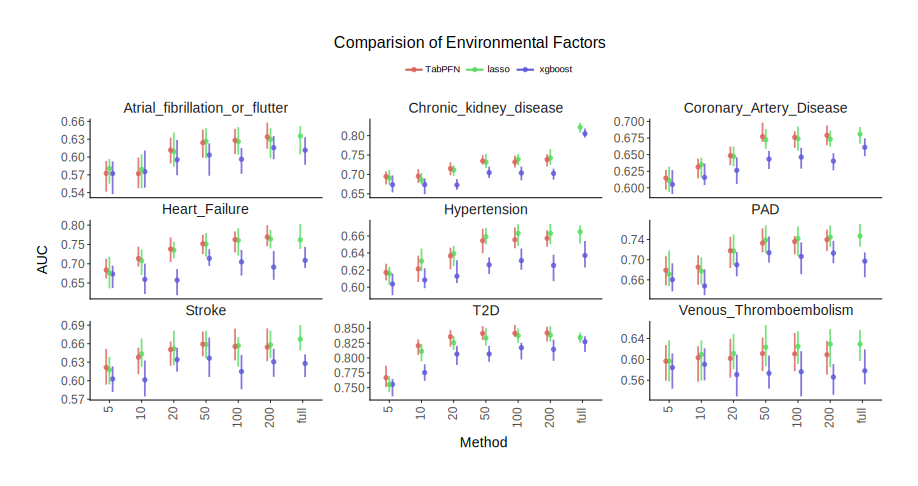

In [34]:
from plotnine import * 
p = (
    ggplot(
        data=res_df,
        mapping=aes(x="ratio", y="AUC", color="base_method"),
    )
    + facet_wrap("disease", scales="free_y")
    + geom_line(
        size=1,
        # color="black",
        mapping = aes(color = "base_method")
    )
    + geom_point(alpha=0.8, size=2, position=position_dodge(width=0.3), na_rm=True)
    # + geom_jitter(width=0.1, height=0.1)
    + geom_linerange(
        mapping=aes(ymin="AUC_LCI", ymax="AUC_UCI"),
        size=1,
        alpha=0.8,
        position=position_dodge(width=0.3),
        na_rm=True,
    )
    + theme_classic( base_size=12)  # 使用Tufte主题
    + theme(axis_line=element_line())
    + theme(
        figure_size=(12, 6),
        legend_position="top",
        axis_text_x=element_text(angle=90),
        strip_background=element_blank(),
        axis_text=element_text(size=12),  # 调整轴文字大小
        axis_title=element_text(size=14),  # 调整轴标题大小和样式
        legend_title=element_text(size=14),  # 调整图例标题大小和样式
        legend_text=element_text(),  # 调整图例文字大小
        strip_text=element_text(size=14),  # 调整分面标签的大小和样式
        plot_title=element_text(size=16, hjust=0.5),  # 添加图表标题并居中
        # plot_margin = margin(10, 10, 10, 10)  # 设置图表边距
    )
    + guides(color=guide_legend(nrow=1, title=""))

    + labs(
        x="Method",  # 设置X轴标签
        y="AUC",  # 设置Y轴标签
        # color="group",  # 设置图例标题
        title="Comparision of Environmental Factors",  # 添加图表标题
    )
)

p

In [11]:
from plotnine import * 
p = (
    ggplot(
        data=res_df,
        mapping=aes(x="method", y="AUC", color="method"),
    )
    + facet_wrap("disease", scales="free_y")
    + geom_hline(
        data=res_df.query("method == 'AutoTabPFN'"),
        mapping=aes(yintercept="AUC"),
        linetype="dashed",  # shixian
        color="#bebebe",
    )
    + geom_hline(
        data=res_df.query("method == 'lasso_full'"),
        mapping=aes(yintercept="AUC"),
        linetype="dashed",
        color="#377eb8",
    )
    # + geom_hline(
    #     yintercept=0.5,
    #     linetype="dashed",
    #     color="black",
    # )
    + geom_point(alpha=0.8, size=2, position=position_dodge(width=0.3), na_rm=True)
    # + geom_jitter(width=0.1, height=0.1)
    + geom_linerange(
        mapping=aes(ymin="AUC_LCI", ymax="AUC_UCI"),
        size=1,
        alpha=0.8,
        position=position_dodge(width=0.3),
        na_rm=True,
    )
    + theme_classic(base_family="Calibri", base_size=12)  # 使用Tufte主题
    + theme(axis_line=element_line())
    + theme(
        figure_size=(12, 6),
        legend_position="top",
        axis_text_x=element_text(angle=90),
        strip_background=element_blank(),
        axis_text=element_text(size=12),  # 调整轴文字大小
        axis_title=element_text(size=14),  # 调整轴标题大小和样式
        legend_title=element_text(size=14),  # 调整图例标题大小和样式
        legend_text=element_text(),  # 调整图例文字大小
        strip_text=element_text(size=14),  # 调整分面标签的大小和样式
        plot_title=element_text(size=16, hjust=0.5),  # 添加图表标题并居中
        # plot_margin = margin(10, 10, 10, 10)  # 设置图表边距
    )
    + guides(color=guide_legend(nrow=1, title=""))
    + scale_color_manual(
        values=color_dict,
    )
    + labs(
        x="Method",  # 设置X轴标签
        y="C-index",  # 设置Y轴标签
        # color="group",  # 设置图例标题
        title="Comparision of Environmental Factors",  # 添加图表标题
    )
    # + coord_flip()
)
print(p)

NameError: name 'color_dict' is not defined